In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import datetime
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
import os
os.listdir(os.getcwd())

['Feb17_Literature Review_KN (edit draft here).docx',
 'Exploratory data -Olympics venues',
 'Data Mining Techniques for Predicting Real Estate Trends.pdf',
 'Exploratory data.ipynb',
 'Predict_Prices_Airbnb_3Cities.pdf',
 'Prediction.ipynb',
 'July_listing.csv',
 '.DS_Store',
 'Mar_cal.csv',
 'Airbnb Price prediction.pdf',
 'Prediction notes',
 'Aug_listing.csv',
 'Untitled.ipynb',
 'Jan27_KN_Abstract.pdf',
 'April6_KN_Report.docx',
 'Aug_cal.csv',
 'WuYu_HousingPrice_report.pdf',
 'Machine Learning Project_ Predicting Boston House Prices With Regression.pdf',
 'Big_Data_in_Real_Estate_From_.pdf',
 'Feb24_Literature Review_KN (clean copy here).docx',
 'TTS_dataset',
 'Neighbourhoods & Olympic venues.ipynb',
 'Multi-Scale clustering.pdf',
 'March 23_KN (clean copy here).docx',
 'July_cal.csv',
 'Abstract.docx',
 'CKME_136_Data_Analytics__Capstone_Course_Winter_2020.pdf',
 '.ipynb_checkpoints',
 'Nov_listing.csv',
 'Estimating_the_Performance_of_.pdf',
 'Mar_listing.csv',
 'Initial resu

In [3]:
# Only using August data for prediction (2019-2020)
calendar = pd.read_csv('Aug_cal.csv')
print('The duration of calendar data is between {} and {}.'.format(calendar['date'].min(), calendar['date'].max()))

The duration of calendar data is between 2019-08-31 and 2020-08-29.


In [4]:
listing = pd.read_csv('Aug_listing.csv')
print('The duration of listing data is between {} and {}.'.format(listing['last_scraped'].min(), listing['last_scraped'].max()))

The duration of listing data is between 2019-08-31 and 2019-08-31.


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
calendar.shape[0]

4539870

In [6]:
listing.shape[0]

12438

In [7]:
#Change all price variables to float and remove $ sign
calendar["price"] = calendar["price"].str.replace("[$, ]", "").astype(float)
calendar["adjusted_price"] = calendar["adjusted_price"].str.replace("[$, ]", "").astype(float)
listing['price'] = listing['price'].str.replace("[$, ]", "").astype(float)
listing['weekly_price'] = listing['weekly_price'].str.replace("[$, ]", "").astype(float)
listing['monthly_price'] = listing['monthly_price'].str.replace("[$, ]", "").astype(float)

In [8]:
# Identify outliers
print('The maximum price is {}.'.format(calendar['price'].max()))
print('The minimum price is {}.'.format(calendar['price'].min()))
print('The average price is {}.'.format(calendar['price'].mean()))

The maximum price is 12761392.0.
The minimum price is 400.0.
The average price is 21625.405522404828.


In [9]:
# The maximum price looks like an outlier. Therefore, we'll drop outliers.
# One definition of outlier is any data point more than 1.5 interquartile ranges (IQRs) below the first quartile or above the third quartile.
# Computing IQR
Q1 = calendar['price'].quantile(0.25)
Q3 = calendar['price'].quantile(0.75)
IQR = Q3 - Q1

In [10]:
# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
calendar = calendar.query('(@Q1 - 1.5 * @IQR) <= price <= (@Q3 + 1.5 * @IQR)')
calendar.shape[0]

4166633

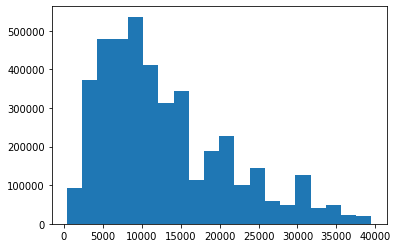

In [11]:
plt.hist(calendar['price'], bins = 20);

In [12]:
print('The maximum number of nights is {}.'.format(calendar['maximum_nights'].max()))
print('The minimum number of nights is {}.'.format(calendar['maximum_nights'].min()))
print('The average number of nights is {}.'.format(calendar['maximum_nights'].mean()))

The maximum number of nights is 3000.
The minimum number of nights is 1.
The average number of nights is 716.0885021550974.


In [13]:
#Drop rows where maximum nights is more than 180 nights (6 months)#
max_nights = 181
mask = (calendar['maximum_nights'] < max_nights)
new_calendar = calendar[mask]
new_calendar.shape[0]

1167471

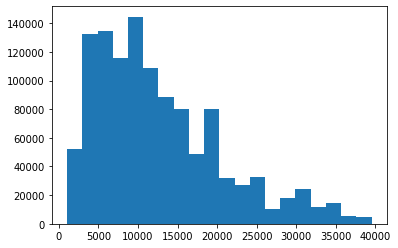

In [14]:
plt.hist(new_calendar['price'], bins = 20);

In [15]:
print('The maximum price is {}.'.format(listing['price'].max()))
print('The minimum price is {}.'.format(listing['price'].min()))
print('The average price is {}.'.format(listing['price'].mean()))

The maximum price is 1063875.0.
The minimum price is 0.0.
The average price is 15547.753175751728.


In [16]:
# The maximum price looks like an outlier. Therefore, we'll drop outliers.
# One definition of outlier is any data point more than 1.5 interquartile ranges (IQRs) below the first quartile or above the third quartile.
# Computing IQR
Q1 = listing['price'].quantile(0.25)
Q3 = listing['price'].quantile(0.75)
IQR = Q3 - Q1

In [17]:
# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
listing = listing.query('(@Q1 - 1.5 * @IQR) <= price <= (@Q3 + 1.5 * @IQR)')
listing.shape[0]

11769

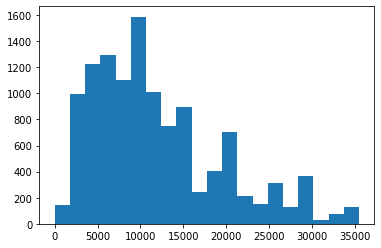

In [18]:
plt.hist(listing['price'], bins=20);

In [19]:
new_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
1702,289597,2019-08-31,f,4360.0,4360.0,30,180
1703,289597,2019-09-01,f,4466.0,4466.0,30,180
1704,289597,2019-09-02,f,4466.0,4466.0,30,180
1705,289597,2019-09-03,f,4573.0,4573.0,30,180
1706,289597,2019-09-04,f,4573.0,4573.0,30,180


In [20]:
listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,35303,https://www.airbnb.com/rooms/35303,20190831051057,2019-08-31,"La Casa Gaienmae C Harajuku, Omotesando is nearby",This shared flat is locating at very close to ...,This apartment is 3 bedroom flat shared with t...,This shared flat is locating at very close to ...,none,10 min walking to Harajuku ~ Urahara ~ Omotesa...,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.19
1,197677,https://www.airbnb.com/rooms/197677,20190831051057,2019-08-31,Oshiage Holiday Apartment,NaN,"We are happy to welcome you to our apartment, ...","We are happy to welcome you to our apartment, ...",none,NaN,...,f,f,moderate,f,f,1,1,0,0,1.64
2,289597,https://www.airbnb.com/rooms/289597,20190831051057,2019-08-31,Private apt in central Tokyo #203,NaN,::::::::::::::::::::::::::::::::::::::::::::::...,::::::::::::::::::::::::::::::::::::::::::::::...,none,NaN,...,t,f,strict_14_with_grace_period,f,f,2,2,0,0,1.23
3,370759,https://www.airbnb.com/rooms/370759,20190831051057,2019-08-31,"Cozy flat #203, local area YET 10 mins to shib...","So close to busy centers, yet so peaceful! Jus...","Cozy and Relaxing, at home feeling in a reside...","So close to busy centers, yet so peaceful! Jus...",none,Peaceful and residential area just 10 mins awa...,...,f,f,strict_14_with_grace_period,f,f,3,3,0,0,1.51
4,700253,https://www.airbnb.com/rooms/700253,20190831051057,2019-08-31,Private apt in central Tokyo #201,NaN,::::::::::::::::::::::::::::::::::::::::::::::...,::::::::::::::::::::::::::::::::::::::::::::::...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,1.22


In [21]:
# Rename 'id' variable in listing to 'listing_id'
listing = listing.rename(index=str, columns={"id": "listing_id"})

In [22]:
# Create new variable month and drop not needed variables
new_calendar['date'] = pd.to_datetime(new_calendar['date'])
new_calendar['month'] = new_calendar.date.dt.month
df_calendar = new_calendar.drop(['date','available','adjusted_price','price'], axis=1)
df_listing = listing.drop(['minimum_nights','maximum_nights'], axis=1)

# Merge calendar and listing data onmerge
df_new = pd.merge(df_calendar, df_listing, on = 'listing_id')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
df_new.head()

,listing_id,minimum_nights,maximum_nights,month,listing_url,scrape_id,last_scraped,name,summary,space,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,289597,30,180,8,https://www.airbnb.com/rooms/289597,20190831051057,2019-08-31,Private apt in central Tokyo #203,NaN,::::::::::::::::::::::::::::::::::::::::::::::...,...,t,f,strict_14_with_grace_period,f,f,2,2,0,0,1.23
1,289597,30,180,9,https://www.airbnb.com/rooms/289597,20190831051057,2019-08-31,Private apt in central Tokyo #203,NaN,::::::::::::::::::::::::::::::::::::::::::::::...,...,t,f,strict_14_with_grace_period,f,f,2,2,0,0,1.23
2,289597,30,180,9,https://www.airbnb.com/rooms/289597,20190831051057,2019-08-31,Private apt in central Tokyo #203,NaN,::::::::::::::::::::::::::::::::::::::::::::::...,...,t,f,strict_14_with_grace_period,f,f,2,2,0,0,1.23
3,289597,30,180,9,https://www.airbnb.com/rooms/289597,20190831051057,2019-08-31,Private apt in central Tokyo #203,NaN,::::::::::::::::::::::::::::::::::::::::::::::...,...,t,f,strict_14_with_grace_period,f,f,2,2,0,0,1.23
4,289597,30,180,9,https://www.airbnb.com/rooms/289597,20190831051057,2019-08-31,Private apt in central Tokyo #203,NaN,::::::::::::::::::::::::::::::::::::::::::::::...,...,t,f,strict_14_with_grace_period,f,f,2,2,0,0,1.23


In [24]:
# Find percentage of missing values in each column in Listing dataset
listing_missing_df = listing.isnull().mean()*100
listing_missing_df
# Filter out only the columns with missing values, showing the percentage of missing values in each column.
listing_nan_cols = listing_missing_df[listing_missing_df > 0]
listing_nan_cols

summary                           1.011131
space                            12.592404
description                       0.832696
neighborhood_overview            20.273600
notes                            25.660634
transit                          15.115983
access                           26.603790
interaction                      24.114198
house_rules                      40.844592
thumbnail_url                   100.000000
medium_url                      100.000000
xl_picture_url                  100.000000
host_location                     0.025491
host_about                       28.719517
host_response_time                3.407256
host_response_rate                3.407256
host_acceptance_rate            100.000000
host_neighbourhood               13.680007
neighbourhood                    11.037471
neighbourhood_group_cleansed    100.000000
city                              0.220919
state                             1.707877
zipcode                           6.364177
market     

In [25]:
# Drop columns with null values of 20% and above & variables not needed to analysis (i.e. listing URL)
# The columns to drop are 'neighborhood_overview','notes','access','interaction','house_rules','thumbnail_url', 
# 'medium_url','xl_picture_url','host_about','host_acceptance_rate','neighbourhood_group_cleansed',
# 'jurisdiction_names', 'square_feet', 'weekly_price', 'monthly_price','notes','transit','access','interaction',
# 'listing_id','name','summary','space','description','experiences_offered','host_id','host_about','host_url','host_name',
# 'host_location','host_thumbnail_url','host_picture_url','street','host_neighbourhood','host_verifications',
# 'smart_location','state','city','market','country_code','country','zipcode','calendar_updated','minimum_minimum_nights',
# 'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
# 'calendar_last_scraped','first_review','last_review','amenities','license','calculated_host_listings_count',
# 'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms'
# 'name','transit', 'picture_url' 
columns_to_drop = ['name','thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate', 
                   'neighbourhood_group_cleansed', 'jurisdiction_names', 'square_feet', 'weekly_price', 
                   'monthly_price', 'house_rules', 'host_about', 'access', 'interaction', 'notes', 'cancellation_policy', 'is_location_exact', 'requires_license',
                   'require_guest_profile_picture', 'require_guest_phone_verification',
                   'neighborhood_overview', 'listing_url', 'scrape_id', 'last_scraped', 'calendar_last_scraped', 'city',
                      'state','listing_id','name','summary','space','transit','picture_url','host_since',
'description','experiences_offered','host_id','host_about','host_url','host_name','host_location','host_thumbnail_url',
'host_picture_url','neighbourhood','street','host_neighbourhood','host_verifications','smart_location','state','city',
'market','country_code','country','zipcode','calendar_updated','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','first_review','last_review','amenities','license',
'calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']
df_new_clean = df_new.drop(columns_to_drop, axis=1)
df_new_clean.dropna(inplace=True)
df_new_clean.shape[0]

915231

In [26]:
df_new_clean.head()

,minimum_nights,maximum_nights,month,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,reviews_per_month
0,30,180,8,within a day,88%,f,2,2,t,t,...,95.0,9.0,10.0,10.0,9.0,9.0,9.0,t,f,1.23
1,30,180,9,within a day,88%,f,2,2,t,t,...,95.0,9.0,10.0,10.0,9.0,9.0,9.0,t,f,1.23
2,30,180,9,within a day,88%,f,2,2,t,t,...,95.0,9.0,10.0,10.0,9.0,9.0,9.0,t,f,1.23
3,30,180,9,within a day,88%,f,2,2,t,t,...,95.0,9.0,10.0,10.0,9.0,9.0,9.0,t,f,1.23
4,30,180,9,within a day,88%,f,2,2,t,t,...,95.0,9.0,10.0,10.0,9.0,9.0,9.0,t,f,1.23


In [27]:
#Identify which columns from 'df_new2' have mixed data types
list(df_new_clean.select_dtypes(['object']).columns)

['host_response_time',
 'host_response_rate',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'security_deposit',
 'cleaning_fee',
 'extra_people',
 'has_availability',
 'instant_bookable',
 'is_business_travel_ready']

In [28]:
# Categorical variables -> host_response_time, cancellation_policy, neighbourhood_cleansed, property_type, room_type, bed_type

# Numerical variables -> host_response_rate, host_listings_count, host_total_listings_count, accommodates, bathrooms, 
# bedrooms, beds, security_deposit, cleaning_fee, guests_included,  availability_30, 
# availability_60, availability_90, availability_365, number_of_reviews, number_of_reviews_ltm, review_scores_rating, 
# review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, 
# review_scores_value, reviews_per_month, month, longitude, latitude, host_response_rate, security_deposit, cleaning_fee, extra_people, host_is_superhost
# host_has_profile_pic, host_identity_verified, has_availability, instant_bookable, is_business_travel_ready, minimum_nights, maximum_nights

# Convert categorical variables to string 
df_new_clean = df_new_clean.astype({'host_response_time': str, 'neighbourhood_cleansed': str, 'property_type': str,
                                   'room_type': str, 'bed_type': str})

# Change 'object' datatype to numeric -> host_response_rate, security_deposit, cleaning_fee, extra_people, 
df_new_clean["host_response_rate"] = df_new_clean["host_response_rate"].str.replace("%", "")
df_new_clean["security_deposit"] = df_new_clean["security_deposit"].str.replace("[$, ]", "")
df_new_clean["cleaning_fee"] = df_new_clean["cleaning_fee"].str.replace("[$, ]", "")
df_new_clean["extra_people"] = df_new_clean["extra_people"].str.replace("[$, ]", "")
df_new_clean = df_new_clean.astype({'host_response_rate': float, 'security_deposit': float, 'cleaning_fee': float, 'extra_people': float, 'number_of_reviews': float})

#Re-assign t/f values into 1/0 -> host_is_superhost, host_has_profile_pic, host_identity_verified, 
# has_availability, instant_bookable, is_business_travel_ready
df_new_clean['host_is_superhost'] = df_new_clean['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
df_new_clean['host_has_profile_pic'] = df_new_clean['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0)
df_new_clean['host_identity_verified'] = df_new_clean['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)
df_new_clean['has_availability'] = df_new_clean['has_availability'].apply(lambda x: 1 if x == 't' else 0)
df_new_clean['instant_bookable'] = df_new_clean['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)
df_new_clean['is_business_travel_ready'] = df_new_clean['is_business_travel_ready'].apply(lambda x: 1 if x == 't' else 0)
df_new_clean = df_new_clean.astype({'host_is_superhost': float, 'host_has_profile_pic': float, 'host_identity_verified': float, 'has_availability': float, 'instant_bookable': float, 'is_business_travel_ready': float})

In [29]:
# Descriptive statistics for 'price' in df_new_clean data
middle = (len(df_new_clean['price'])/2) + 0.5
sorted_price = sorted(df_new_clean['price'])
import statistics
from scipy import stats

print('The Mean of Price is %.4f' % (round(np.mean(df_new_clean['price']))))
print('The Median of Price is %.4f' % (statistics.median(sorted_price)))
print('The Standard Deviation of Price is %.4f' % (np.std(df_new_clean['price'])))

The Mean of Price is 11791.0000
The Median of Price is 9996.0000
The Standard Deviation of Price is 7386.4899


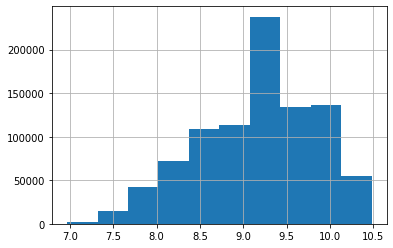

In [30]:
df_new_clean['price'].apply(lambda x: np.log(x+1)).hist() 
plt.show()

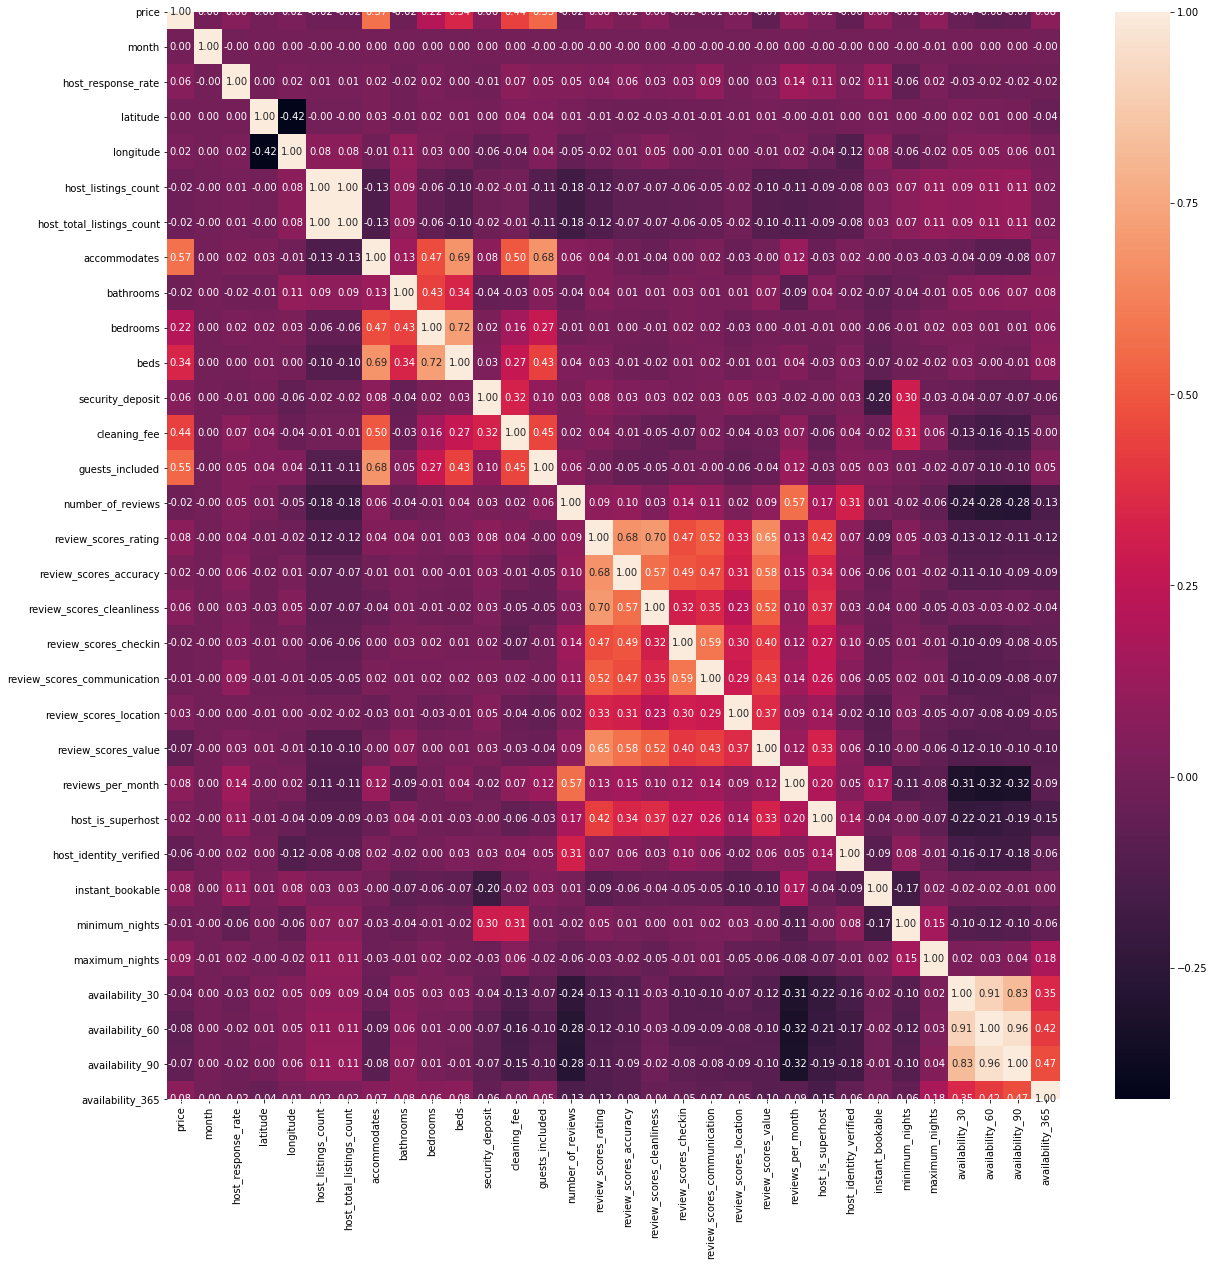

In [31]:
# Find out the correlations among numerical variables
cols = ['price','month','host_response_rate','latitude', 'longitude','host_listings_count','host_total_listings_count',
        'accommodates','bathrooms','bedrooms', 'beds', 'security_deposit','cleaning_fee','guests_included',
        'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location',
        'review_scores_value', 'reviews_per_month','host_is_superhost','host_identity_verified',
'instant_bookable','minimum_nights', 'maximum_nights','availability_30','availability_60','availability_90','availability_365']
plt.figure(figsize=(20,20))
sns.heatmap(df_new_clean[cols].corr(), annot=True, fmt='.2f');

In [32]:
# Pull a list of the column names of the categorical variables
cat_df = df_new_clean.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

In [33]:
# One-Hot Encoding - Convert Categorical variables into numerical representation without arbitrary ordering
def create_dummy_df(df, cat_cols, dummy_na):
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

df_new_clean_cat = create_dummy_df(df_new_clean, cat_cols_lst, dummy_na=False)
df_new_clean_cat.head()

,minimum_nights,maximum_nights,month,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,...,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Villa,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,30,180,8,88.0,0.0,2,2,1.0,1.0,35.74267,...,0,0,0,0,0,0,0,0,0,1
1,30,180,9,88.0,0.0,2,2,1.0,1.0,35.74267,...,0,0,0,0,0,0,0,0,0,1
2,30,180,9,88.0,0.0,2,2,1.0,1.0,35.74267,...,0,0,0,0,0,0,0,0,0,1
3,30,180,9,88.0,0.0,2,2,1.0,1.0,35.74267,...,0,0,0,0,0,0,0,0,0,1
4,30,180,9,88.0,0.0,2,2,1.0,1.0,35.74267,...,0,0,0,0,0,0,0,0,0,1


In [34]:
df_new_clean_cat.shape[0]

915231

In [35]:
sampled_data = df_new_clean_cat.sample(frac=0.02)
sampled_data.shape[0]

18305

In [36]:
# Convert numerical data into array:
# Labels are the values we want to predict
labels = np.array(sampled_data['price'])
# Remove the labels from the features
# axis 1 refers to the columns
features = sampled_data.drop('price', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [37]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
test_size = 0.2, stratify = labels, random_state = 42, shuffle = True)

In [38]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (14644, 113)
Training Labels Shape: (14644,)
Testing Features Shape: (3661, 113)
Testing Labels Shape: (3661,)


In [39]:
# Feature scaling with Standard Scaler # Train the model using the training sets
scaler = StandardScaler()
X = train_features

# Fit on training set only.
scaler.fit(train_features)

# Apply transform to both the training set and the test set.
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

# Make an instance of the Model - retain only 10 components of data dimension
pca = PCA(n_components=10)


# Fit PCA only on training set
pca.fit(train_features)
X_pca = pca.transform(X)
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
print("Original Shape:   ", X.shape)
print("Transformed Shape:", X_pca.shape)

Original Shape:    (14644, 113)
Transformed Shape: (14644, 10)


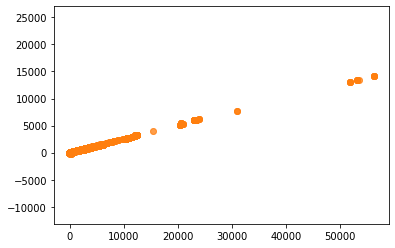

In [40]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.5)
plt.axis('equal');

Text(0, 0.5, 'Second Principal Component')

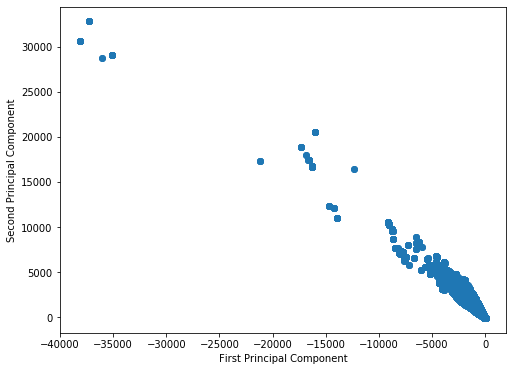

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0],X_pca[:,1],cmap='rainbow')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

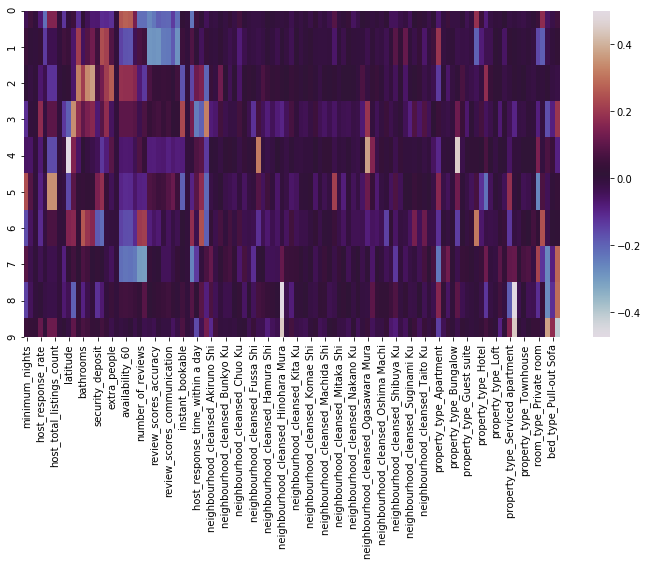

In [42]:
map= pd.DataFrame(pca.components_,columns=feature_list)
plt.figure(figsize=(12,6))
sns.heatmap(map,cmap='twilight')

In [45]:
# Convert numerical data into array:
# Labels are the values we want to predict
labels = np.array(sampled_data['price'])
# Remove the labels from the features
# axis 1 refers to the columns
features = sampled_data.drop('price', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [46]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
test_size = 0.2, stratify = labels, random_state = 42, shuffle = True)

In [47]:
print('Training Features Shape:', X_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (14644, 113)
Testing Features Shape: (3661, 113)
Training Labels Shape: (14644,)
Testing Labels Shape: (3661,)


In [78]:
# SelectFromModel & LassoCV
from sklearn.feature_selection import SelectFromModel
clf = LassoCV(eps = 0.001, cv = 5, random_state = 42, max_iter = 10000, tol = 0.0001)
clf.fit(train_features, train_labels)

# Make predictions using the testing set
test_labels_pred = clf.predict(test_features)

In [79]:
# Measure L1 performance 
clf.score(test_features, test_labels)

0.3284598217944459

In [80]:
# Get data dimension for PCA-transformed train & test features
print('train_features Shape:', train_features.shape)
print('test_features Shape:', test_features.shape)

train_features Shape: (14644, 10)
test_features Shape: (3661, 10)


ValueError: x and y must be the same size

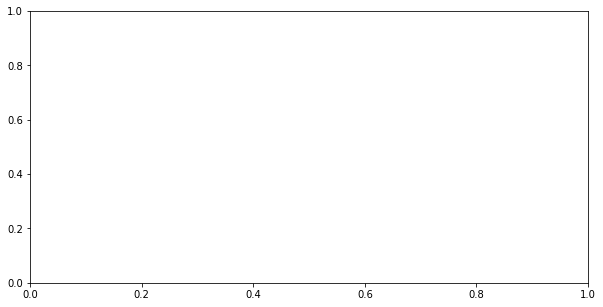

In [81]:
# Graph LassoCV prediction results 
plt.figure(figsize=(10, 5))
plt.scatter(test_features, test_labels_pred, s=20)
rmse_pred_vs_actual = self.rmse(test_labels_pred, test_features)
plt.title(''.join([title_name, ', Predicted vs. Actual.', ' rmse = ', str(rmse_pred_vs_actual)]))
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.plot([min(test_features), max(test_features)], [min(test_features), max(test_features)])
plt.tight_layout() 

In [82]:
# Calculate scores for the L1 model
test_labels_pred = clf.predict(test_features)
train_labels_pred = clf.predict(train_features)
print('Training error:', train_labels_pred)
print('Validation error:', test_labels_pred)

# Calculate the absolute errors
errors_train = abs(train_labels_pred - train_labels)
errors_test = abs(test_labels_pred - test_labels)

# Print out the mean absolute error (MAE), to compare to baseline
print('Mean Absolute Error, train: %.4f, test: %.4f' % (
        round(np.mean(errors_train)),
        round(np.mean(errors_test))))

# Print out the mean squared error (MSE)
print('MSE train: %.4f, test: %.4f' % (
        mean_squared_error(train_labels, train_labels_pred),
        mean_squared_error(test_labels, test_labels_pred)))

from math import sqrt

# Print out the root mean squared error (RMSE)
print('RMSE train: %.4f, test: %.4f' % (
        sqrt(mean_squared_error(train_labels, train_labels_pred)),
        sqrt(mean_squared_error(test_labels, test_labels_pred))))

# Print out the R-squared value (R²)
print('R^2 train: %.4f, test: %.4f' % (
        r2_score(train_labels, train_labels_pred),
        r2_score(test_labels, test_labels_pred)))

Training error: [15872.49740307 17784.54078385  8252.93175438 ...  4872.03219737
  8068.36055196 15603.7964092 ]
Validation error: [16969.44225515  7969.32498367 11990.04550409 ... 12311.44751322
  8677.66630547 13185.55476782]
Mean Absolute Error, train: 4595.0000, test: 4559.0000
MSE train: 36806338.1870, test: 36559537.6772
RMSE train: 6066.8227, test: 6046.4484
R^2 train: 0.3243, test: 0.3285


In [67]:
# Feature scaling with Standard Scaler # Fit on training set only.
scaler = StandardScaler()
scaler.fit(X_train, y_train)

# Apply transform to both the training set and the test set.
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [83]:
# LassoCV with feature scaling
clf = LassoCV(eps = 0.001, cv = 5, random_state = 42, max_iter = 10000, tol = 0.0001)
clf.fit(X_train, y_train)

# Make predictions using the testing set
ytest_pred = clf.predict(X_test)

clf.score(X_test, y_test)

0.21169058667470572

In [77]:
# Calculate scores for the L1 model
ytrain_pred = clf.predict(X_train)
print('Training error:', ytrain_pred)
print('Validation error:', ytest_pred)

# Calculate the absolute errors
errors_train = abs(ytrain_pred - y_train)
errors_test = abs(ytest_pred - y_test)

# Print out the mean absolute error (MAE), to compare to baseline
print('Mean Absolute Error, train: %.4f, test: %.4f' % (
        round(np.mean(errors_train)),
        round(np.mean(errors_test))))

# Print out the mean squared error (MSE)
print('MSE train: %.4f, test: %.4f' % (
        mean_squared_error(y_train, ytrain_pred),
        mean_squared_error(y_test, ytest_pred)))

from math import sqrt

# Print out the root mean squared error (RMSE)
print('RMSE train: %.4f, test: %.4f' % (
        sqrt(mean_squared_error(y_train, ytrain_pred)),
        sqrt(mean_squared_error(y_test, ytest_pred))))

# Print out the R-squared value (R²)
print('R^2 train: %.4f, test: %.4f' % (
        r2_score(y_train, ytrain_pred),
        r2_score(y_test, ytest_pred)))

Training error: [ 9098.33328341 14882.11996745 10424.51581764 ...  8504.46793952
 11158.9869506  13385.33798433]
Validation error: [16485.85844317 12764.71680358  7100.93138312 ... 12333.32942705
 13788.92749176  7832.49855568]
Mean Absolute Error, train: 5055.0000, test: 5099.0000
MSE train: 43199931.7424, test: 42974956.0467
RMSE train: 6572.6655, test: 6555.5287
R^2 train: 0.2067, test: 0.2117


In [73]:
# KFold
X = features
y = labels
kf = KFold(n_splits=5, random_state=42, shuffle=True) 
for train_index, test_index in kf.split(sampled_data):
        print('train: %s, test: %s' % (train_index, test_index))
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

train: [    1     2     4 ... 18301 18302 18304], test: [    0     3     8 ... 18280 18296 18303]
train: [    0     1     2 ... 18302 18303 18304], test: [    5    14    15 ... 18278 18292 18294]
train: [    0     1     2 ... 18302 18303 18304], test: [   10    12    17 ... 18293 18300 18301]
train: [    0     3     5 ... 18302 18303 18304], test: [    1     2     4 ... 18285 18289 18299]
train: [    0     1     2 ... 18300 18301 18303], test: [    6     7     9 ... 18298 18302 18304]


In [85]:
# Feature scaling with Standard Scaler # Fit on training set only.
scaler = StandardScaler()
scaler.fit(X_train, y_train)


# SVM
svr = SVR(kernel='rbf', C=1, gamma=1)
svr.fit(X_train, y_train)
ytest_pred = svr.predict(X_test)

svr.score(X_test, y_test)

-0.055209055071490765

In [87]:
# Calculate scores for the L1 model
ytrain_pred = svr.predict(X_train)
ytest_pred = svr.predict(X_test)
print('Training error:', ytrain_pred)
print('Validation error:', ytest_pred)

# Calculate the absolute errors
errors_train = abs(ytrain_pred - y_train)
errors_test = abs(ytest_pred - y_test)

# Print out the mean absolute error (MAE), to compare to baseline
print('Mean Absolute Error, train: %.4f, test: %.4f' % (
        round(np.mean(errors_train)),
        round(np.mean(errors_test))))

# Print out the mean squared error (MSE)
print('MSE train: %.4f, test: %.4f' % (
        mean_squared_error(y_train, ytrain_pred),
        mean_squared_error(y_test, ytest_pred)))

from math import sqrt

# Print out the root mean squared error (RMSE)
print('RMSE train: %.4f, test: %.4f' % (
        sqrt(mean_squared_error(y_train, ytrain_pred)),
        sqrt(mean_squared_error(y_test, ytest_pred))))

# Print out the R-squared value (R²)
print('R^2 train: %.4f, test: %.4f' % (
        r2_score(y_train, ytrain_pred),
        r2_score(y_test, ytest_pred)))

Training error: [9993.81253666 9997.59078464 9996.10015355 ... 9995.16210046 9997.1804161
 9997.54829554]
Validation error: [9996.5666113  9996.2171709  9996.54829554 ... 9996.14933797 9997.30274519
 9994.79422102]
Mean Absolute Error, train: 5596.0000, test: 5635.0000
MSE train: 57657298.2854, test: 57525080.8823
RMSE train: 7593.2403, test: 7584.5290
R^2 train: -0.0588, test: -0.0552


In [90]:
# Feature scaling with Standard Scaler # Fit on training set only.
scaler = StandardScaler()
scaler.fit(X_train, y_train)

# Train ML model by only numerical columns, with Random Forest
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
forest = forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.9927358835188278

In [89]:
# Calculate scores for the L1 model
ytrain_pred = forest.predict(X_train)
ytest_pred = forest.predict(X_test)
print('Training error:', ytrain_pred)
print('Validation error:', ytest_pred)

# Calculate the absolute errors
errors_train = abs(ytrain_pred - y_train)
errors_test = abs(ytest_pred - y_test)

# Print out the mean absolute error (MAE), to compare to baseline
print('Mean Absolute Error, train: %.4f, test: %.4f' % (
        round(np.mean(errors_train)),
        round(np.mean(errors_test))))

# Print out the mean squared error (MSE)
print('MSE train: %.4f, test: %.4f' % (
        mean_squared_error(y_train, ytrain_pred),
        mean_squared_error(y_test, ytest_pred)))

from math import sqrt

# Print out the root mean squared error (RMSE)
print('RMSE train: %.4f, test: %.4f' % (
        sqrt(mean_squared_error(y_train, ytrain_pred)),
        sqrt(mean_squared_error(y_test, ytest_pred))))

# Print out the R-squared value (R²)
print('R^2 train: %.4f, test: %.4f' % (
        r2_score(y_train, ytrain_pred),
        r2_score(y_test, ytest_pred)))

Training error: [ 2575.4  11913.12  9996.   ...  9389.48 15656.39 24093.55]
Validation error: [29348.42 18504.   14017.79 ... 10253.41 20950.    3616.  ]
Mean Absolute Error, train: 38.0000, test: 115.0000
MSE train: 35761.4798, test: 396005.7830
RMSE train: 189.1071, test: 629.2899
R^2 train: 0.9993, test: 0.9927


In [91]:
# Convert numerical data into array:
# Labels are the values we want to predict
labels = np.array(sampled_data['price'])
# Remove the labels from the features
# axis 1 refers to the columns
features = sampled_data.drop('price', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [92]:
# Extract feature importances (fi)
for feature in zip(feature_list, forest.feature_importances_):
    print(feature)
    

('minimum_nights', 0.008784188999484474)
('maximum_nights', 0.04284541333223606)
('month', 8.743397516996981e-05)
('host_response_rate', 0.003638278891831333)
('host_is_superhost', 0.005594818903307181)
('host_listings_count', 0.023850324360939864)
('host_total_listings_count', 0.02185156441086877)
('host_has_profile_pic', 0.0)
('host_identity_verified', 0.007809949144242967)
('latitude', 0.05751802691066975)
('longitude', 0.06134740521730562)
('accommodates', 0.2935084481290091)
('bathrooms', 0.012371995997014535)
('bedrooms', 0.010190363454807526)
('beds', 0.01283810050537413)
('security_deposit', 0.013463063183171453)
('cleaning_fee', 0.11233660523285348)
('guests_included', 0.07086821131585251)
('extra_people', 0.031752697755376785)
('has_availability', 0.0)
('availability_30', 0.00970343444640043)
('availability_60', 0.010146230523061286)
('availability_90', 0.011218242255210342)
('availability_365', 0.029767033366152544)
('number_of_reviews', 0.015773151310958126)
('number_of_rev

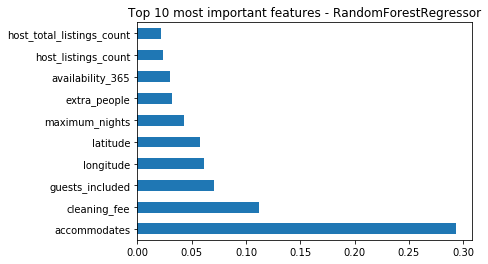

In [93]:
# Top 10 most important features - RandomForestRegressor
plt.figure()
feat_importances = pd.Series(forest.feature_importances_, index=feature_list)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 most important features - RandomForestRegressor")
plt.show()